In [14]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

In [15]:
data = pd.read_csv('squares.csv')
data = data.loc[:, data.columns[6:]]

In [16]:
class GridDataset(Dataset):
    def __init__(self, df):
        columns = [c for c in df.columns if c != "label"]
        self.data = df.loc[:, columns].values.astype(np.float32)
        self.data /= self.data.max(0)
        self.data = torch.tensor(self.data)
        self.labels = df.loc[:, "label"].values

        label_mapping = {label: i for i, label in enumerate(np.unique(self.labels))}
        self.labels = np.array([label_mapping[label] for label in self.labels])

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    
batch_size = 128
full_loader = DataLoader(GridDataset(data), batch_size=batch_size, shuffle=True)

In [17]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output, labels):
        label = (labels[None, :] == labels[:, None]).float().flatten()
        
        # Compute Euclidean distance
        euclidean_distance = nn.functional.pairwise_distance(output[None,:,:], output[:,None,:]).flatten()
        # Loss for positive pairs
        positive_loss = label * torch.pow(euclidean_distance, 2)
        # Loss for negative pairs
        negative_loss = (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        # Combine losses
        loss = torch.mean(positive_loss + negative_loss)
        return loss


In [18]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(Encoder, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim)
        )

    def forward(self, x):
        return self.network(x)


In [19]:
# Initialize model, loss, and optimizer
embedding_dim = 32
encoder = Encoder(input_dim=len(data.columns)-1, embedding_dim=embedding_dim)
loss_fn = ContrastiveLoss(margin=1.0)
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.0001)

writer = SummaryWriter()

# Training loop
n_epochs = 500
pbar = tqdm(total=n_epochs)
try:
    for epoch in range(n_epochs):
        encoder.train()
        epoch_loss = 0.0

        for batch_data, batch_labels in full_loader:

            output = encoder(batch_data)

            # Compute loss
            loss = loss_fn(output, batch_labels)
            epoch_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        writer.add_scalar("encoder/Loss/train", epoch_loss / len(full_loader), epoch)
        pbar.update(1)
        pbar.set_description(f"Loss: {round(epoch_loss / len(full_loader),3)}")
finally:
    pbar.close()
    writer.close()

Loss: 0.22: 100%|██████████| 500/500 [01:58<00:00,  4.22it/s] 


In [20]:
with torch.no_grad():
    embeddings = torch.tensor([])
    labels = []
    for batch_data, batch_labels in full_loader:
        embeddings = torch.cat((embeddings, encoder(batch_data)))
        labels += batch_labels
    labels = torch.tensor(labels)

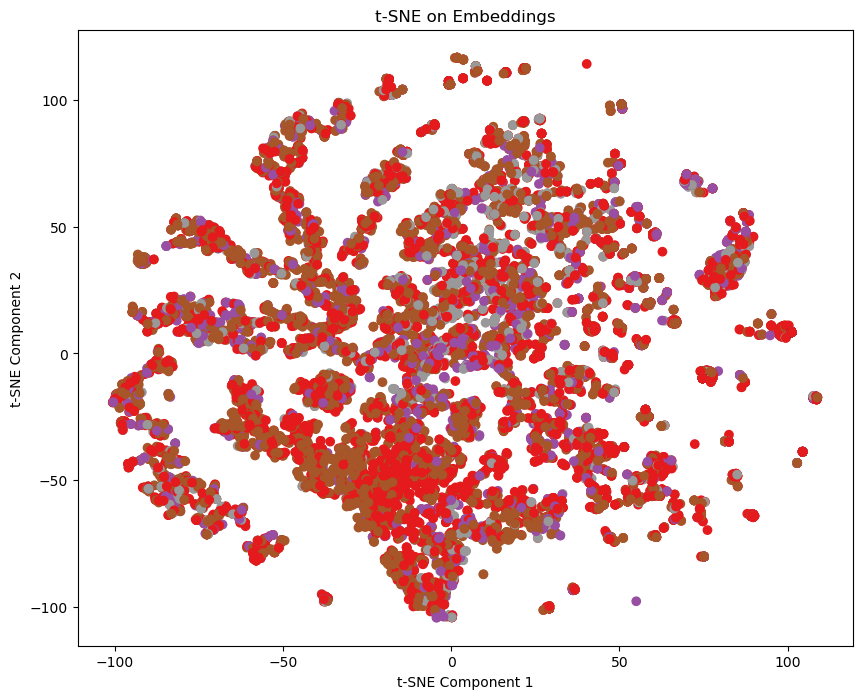

In [21]:
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings.detach().numpy())

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='Set1')
plt.title('t-SNE on Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [22]:
num_samples = labels.unique(return_counts=True)[1].max()
indices = []
for label in labels.unique():
    label_indices = (labels == label).nonzero(as_tuple=True)[0]
    repeated_indices = label_indices[torch.randint(len(label_indices), (num_samples,))]
    indices.append(repeated_indices)

indices = torch.cat(indices)
balanced_data = embeddings[indices]
balanced_labels = labels[indices]

              precision    recall  f1-score   support

           0       0.53      0.37      0.44      5778
           1       0.19      0.27      0.22      1900
           2       0.53      0.42      0.46      5365
           3       0.18      0.43      0.25      1441

    accuracy                           0.38     14484
   macro avg       0.36      0.37      0.34     14484
weighted avg       0.45      0.38      0.40     14484



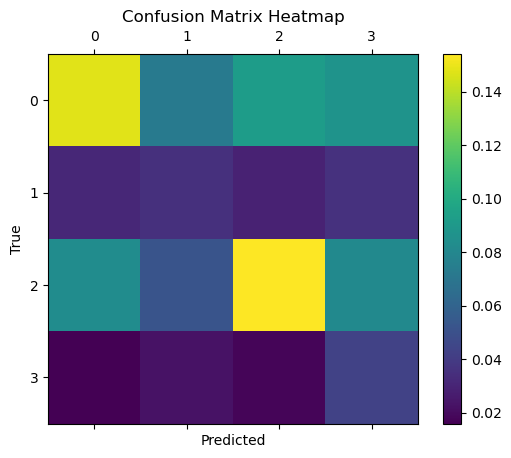

In [23]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Initialize the SVM classifier
svm_classifier = SVC(kernel='linear')

# Train the SVM classifier on the embeddings and labels
svm_classifier.fit(balanced_data.detach().numpy(), balanced_labels.numpy())

# Make predictions on the training data
train_predictions = svm_classifier.predict(embeddings.detach().numpy())

print(classification_report(labels.numpy(), train_predictions))

conf_matrix = np.zeros((len(np.unique(labels)), len(np.unique(labels))))
for i, j in zip(labels.numpy(), train_predictions):
    conf_matrix[i, j] += 1

fig, ax = plt.subplots()
cax = ax.matshow(conf_matrix/conf_matrix.sum(), cmap='viridis')
fig.colorbar(cax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix Heatmap')
plt.show()